# Split-Step Fourier Method
This notebook shows a simple, scalar implementation of the [Split-Step Fourier Method](https://en.wikipedia.org/wiki/Split-step_method) for solving the [Nonlinear Schrodinger Equation](https://https://en.wikipedia.org/wiki/Nonlinear_Schr%C3%B6dinger_equation),

$\frac{\partial A}{\partial z}=-\frac{\alpha}{2}A-i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial T^2}+i\gamma|A|^2A$.

This nonlinear partial differential equation models how the envelope and phase of light pulse changes when propagating through an optical fiber, when taking:

1) **Power Attenuation** ($\alpha$) - decrease in amplitude, 
2) **Group Velocity Dispersion** ($\beta_2$) - delay of existing frequency components, and 
3) waveguide nonlinearity ($\gamma$) causing **Self-Phase Modulation (SPM)** (redistributionof energy into new frequency components) 

into account.

More than 20 tutorial videos are available on [YouTube page](https://https://youtube.com/playlist?list=PLdFybGSAoPnnPkzL8zq6uR1yYZk4Ut_Zv).


## Theoretical Material

### Fourier Transform

**Videos:**
- Fourier Transform: [3B1B Visual Introduction](https://youtu.be/spUNpyF58BY?si=TcDqGewf8nZBcXLd)
- Fourier Series: [3B1B What is a Fourier Series](https://youtu.be/r6sGWTCMz2k?si=MbgrqcbAPYvGPF1p)

## Import useful libraries

In [2]:
import numpy as np
from scipy.fftpack import fft, ifft, fftshift, ifftshift, fftfreq

import matplotlib.pyplot as plt
from matplotlib import cm

global pi; pi=np.pi

## Define simulation parameters


In [3]:
N  = 2**15 #Number of points
dt = 0.1e-12 #Time resolution [s]

## Define function for getting DFT/FFT frequency range from time vector

#### fftfreq()

[fftfreq](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fftfreq.html#scipy.fft.fftfreq) - to describe a bounded-domain (for example time domain looking only at time period $t_max = T = N \cdot dt$) function using fourier anaysis (to determine its FT) it can be done with a discrete set of uniformly distributed exponentials associated with frequencies.

`fftfreq` returns all the bin frequencies from zero to the **Nyquist** frequency - *the highest frequency component that can be accurately resolved in a discretely sampled signal (the maximum frequency that can be represented without aliasing (distortion caused by undersampling))*. 

If the signal contains frequencies higher than the Nyquist frequency, these frequencies will be "folded back" into the lower frequency range, creating artifacts or aliasing. Therefore, the DFT (or FFT) only computes frequencies from 0 up to the Nyquist frequency.

$
f_{\text{Nyquist}} = \frac{f_s}{2}
$

where \( f_s \) is the sampling rate (the number of samples per second). In other words, the Nyquist frequency is half the sampling rate


---

### Fourier Series and the Exponential Form

For a **periodic function** with period $T$, the Fourier series expresses the function as a sum of complex exponentials:

$
f(t) = \sum_{k=-\infty}^{\infty} c_k \, e^{i \frac{2\pi k}{T} t}
$

where $c_k$ are the **Fourier coefficients** given by:

$
c_k = \frac{1}{T} \int_0^T f(t) \, e^{-i \frac{2\pi k}{T} t} \, dt
$

**Any periodic function** can be represented as a sum of harmonically related sinusoids with frequencies that are integer multiples of the fundamental frequency $f_0 = \frac{1}{T} $.

---

### How the DFT Relates to the Fourier Transform

The **DFT** can be seen as a **discrete version** of the continuous Fourier transform. When we sample a signal at discrete intervals and apply the DFT, we obtain the frequency components present in the signal at **discrete frequency bins**.

The **DFT formula** is:

$
X[k] = \sum_{n=0}^{N-1} x[n] \, e^{-i \frac{2\pi k n}{N}} \quad \text{for} \quad k = 0, 1, \dots, N-1
$

This computes the frequency content of the signal at **discrete frequencies** $ \frac{k}{N \cdot d} $. The **inverse DFT** reconstructs the signal using:

$
x[n] = \frac{1}{N} \sum_{k=0}^{N-1} X[k] \, e^{i \frac{2\pi k n}{N}}
$

Thus, the DFT transforms a time-domain signal into a frequency-domain representation consisting of **specific bins**.

---

The **Discrete Fourier Transform (DFT)** only produces a limited number of frequency bins because:

1. We are working with a **finite number of samples**.
2. The samples are spaced at discrete intervals, meaning **only certain harmonics fit naturally within the sampled data**.

For a signal with $ n $ samples, the DFT computes exactly $ n $ complex frequency components. These represent **sinusoids at specific frequencies** that are integer multiples of the fundamental frequency:

$f_0 = \frac{1}{n \cdot d}$ **! This is just the frequency as if the wave started and ended at the first and last data point**

where $d$ is the time interval between samples. The bins generated by the DFT correspond to these discrete frequencies:

$
f_k = \frac{k}{n \cdot d} \quad \text{for} \quad k = 0, 1, 2, \dots, n-1
$

Thus, the DFT only gives frequencies within this set of bins because each bin corresponds to an **integer multiple** of the fundamental frequency.



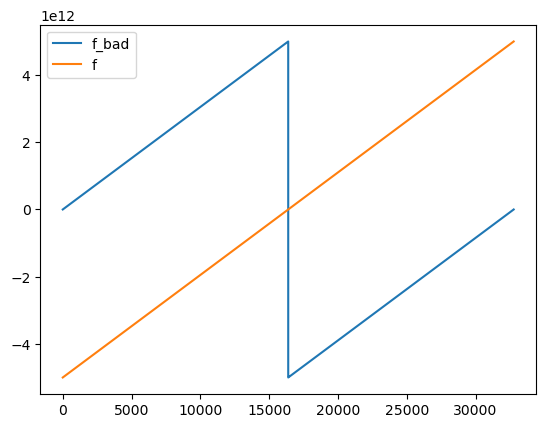

Our time period is:  3.2768  ns
Fundametal frequency should be:  305175781.25  and is:  305166468.0245595


In [4]:
def getFreqRangeFromTime(time):
    return fftshift(fftfreq(len(time), d=time[1]-time[0]))

# Equivalent function for getting time base from frequency range
def getTimeFromFrequency(frequency):
    return fftshift(fftfreq(len(frequency), d=frequency[1]-frequency[0]))

t=np.linspace(0,N*dt,N) #Time step array
t=t-np.mean(t)          #Center so middle entry is t=0

f_unshifted = fftfreq(len(t), d=t[1]-t[0])
f=getFreqRangeFromTime(t)



plt.figure()
plt.plot(f_unshifted,label="f_bad")
plt.plot(f,label="f")
plt.legend()
plt.show()


# Sanity check: the bins are in form [0, 1/(n*d), 2/(n*d), ..., (n/2-1)/(n*d), -n/2/(n*d), ..., -1/(n*d)], so the second element is the fundamental frequency (1/T) - the slowest possible cyclic frequency
print("Our time period is: " , N*dt*1e9, " ns")
print("Fundametal frequency should be: ", 1/(N*dt), " and is: ", f_unshifted[1]) #Fundamental frequency


#NOTE: scipy is (for some reason) coded so the first entry is freq=0, the next
#(N-1)/2 are all the positive frequencies and the remaining ones are the
#negative ones. The function, fftshift, rearranges the entries so negative
#frequencies come first

## Define functions for getting phase and chirp

### np.angle()
`np.angle()` - computes the **phase angle** (in radians) of complex numbers. It extracts the angle (or argument) of each element in an array of complex numbers result is a value in the range $(- \pi, \pi ]$

### np.unwrap()
`np.unwrap()` - corrects the phase angle discontinuities in an array. It ensures that phase values (in radians) change smoothly by adding or subtracting multiples of $2π$, preventing sudden jumps that typically occur in wrapped phase data (from using np.angle() for example, since it restricts values to $(- \pi, \pi ]$).

### np.diff() [docs](https://numpy.org/doc/stable/reference/generated/numpy.diff.html)
`np.fidd()` - computes the difference between consecutive elements of an array along a specified axis. It essentially performs a discrete difference operation, which can be useful in numerical differentiation, finding changes in values, or analyzing trends between adjacent elements

prepend / append: Values to be added to the array before or after computing the difference.


In [5]:
def getPhase(pulse):
    phi=np.unwrap(np.angle(pulse)) #Get phase starting from 1st entry
    phi=phi-phi[int(len(phi)/2)]   #Center phase on middle entry
    return phi

### Chirp [(Wikipedia)](https://en.wikipedia.org/wiki/Chirp)
In optical fibers, **chirp** refers to the **frequency modulation** across a pulse i.e. when different parts of the pulse have different instantaneous frequencies (often due to nonlinear effects or dispersion).

- **Positive chirp**: Higher frequencies lead the pulse - higher frequency components move slower (later parts—in space—have lower frequencies).
- **Negative chirp**: Lower frequencies lead the pulse - lower frequency components move slower (earlier parts—in space—have lower frequencies).

A chirped pulse spreads out in time since its spectral components travel at different speeds in a dispersive medium.

Chirp arises from 2 effects:
- **Group Velocity Dispersion (GVD)**: Linear dispersion effect where **different frequency components propagate at different speeds**.
- **Self-Phase Modulation (SPM)**: Due to Kerr Nonlinearity-nonlinear effect where the **refractive index depends on the pulse intensity**.

---

The **chirp parameter**, denoted $\alpha(t) = \frac{d\omega(t)}{dt}$, quantifies the rate of angular frequency $\omega(t)$ change across the pulse:

$$
\omega(t) = \omega_0 + \alpha(t) \cdot t
$$

where:
- $\omega(t)$: Instantaneous frequency at time $t$
- $\omega_0$: Central frequency
- $\alpha(t)$: Chirp rate

An **unchirped pulse** has $\alpha(t) = 0$ (e.g., transform-limited Gaussian pulse).
**Linearly chirped pulses** arise after nonlinear propagation, such as through self-phase modulation.

Note: We can talk about angular frequency $\omega(t)$ or "ordinary" frequency $f(t) = \frac{\omega(t)}{2 \pi}$, and correspondingly about angular chirp $\frac{d\omega(t)}{dt}$ or simply chirp $\frac{df(t)}{dt} = \frac{d\omega(t)}{dt} \frac{1}{2\pi}$

---

In [6]:
def getChirp(time,pulse): # get chirp df/dt (at each point of the pulse)
    phi=getPhase(pulse)
    dphi=np.diff(phi ,prepend = phi[0] - (phi[1]  - phi[0]  ),axis=0) #Change in phase. Prepend to ensure consistent array size
    dt  =np.diff(time,prepend = time[0]- (time[1] - time[0] ),axis=0) #Change in time.  Prepend to ensure consistent array size

    return -1.0/(2*pi)*dphi/dt #Chirp = - 1/(2pi) * d(phi)/dt

# returns the different ordinary frequencies (of the oscillating wave) encountered by a point in time (through whcih the pulse passes)

Example

In [7]:
a=np.array([0-1j,1+0j,0+1j]) # 3 point pulse

# Phase
ph=getPhase(a)
print("Phase: ", ph, "radians")

# Chirp
ch=getChirp(np.array([-1.0,0.0,1.0]),a)
print("Chirp: ", ch)


Phase:  [-1.57079633  0.          1.57079633] radians
Chirp:  [-0.25 -0.25 -0.25]


##Define class to hold simulation parameters

In [8]:
#Class for holding info about the simulation params
class SIM_config:
    def __init__(self,N,dt): # N - number of points, dt - time step
        self.number_of_points=N
        self.time_step=dt
        t=np.linspace(0,N*dt,N)
        self.t=t-np.mean(t)
        self.tmin=self.t[0]
        self.tmax=self.t[-1]

        self.f=getFreqRangeFromTime(self.t)
        self.fmin=self.f[0]
        self.fmax=self.f[-1]
        self.freq_step=self.f[1]-self.f[0]

        self.describe_config()

    def describe_config(self):
        print("### Configuration Parameters ###")
        print(f" Number of points = {self.number_of_points}")
        print(f" Start time, tmin = {self.tmin*1e12}ps")
        print(f" Stop time, tmax = {self.tmax*1e12}ps")
        print(f" Time resolution, dt = {self.time_step*1e12}ps")
        print("  ")
        print(f" Start frequency= {self.fmin/1e12}THz")
        print(f" Stop frequency = {self.fmax/1e12}THz")
        print(f" Frequency resolution= {self.freq_step/1e6}MHz")
        print( "   ")

#Initialize class
sim_config=SIM_config(N,dt)

### Configuration Parameters ###
 Number of points = 32768
 Start time, tmin = -1638.4ps
 Stop time, tmax = 1638.4ps
 Time resolution, dt = 0.1ps
  
 Start frequency= -4.9998474121143825THz
 Stop frequency = 4.999542245646358THz
 Frequency resolution= 305.1664680244141MHz
   


## Functions for creating a Gaussian pulse to be simulated

### Summary of Gaussian Pulse Code

This function generates a **Gaussian pulse** with parameters such as amplitude, duration, offset, chirp, and order. Below is an explanation of the function components.

```python
def GaussianPulse(time, amplitude, duration, offset, chirp, order):
    assert 1 <= order, f"Error: Order of gaussian pulse is {order}. Must be >=1"
    return amplitude * np.exp(- (1 + 1j * chirp) / 2 * ((time - offset) / duration)**(2 * np.floor(order))) * (1 + 0j)
```
Parameters:

- **`time`**: Input time values (e.g., a NumPy array).
- **`amplitude`**: Peak amplitude of the pulse.
- **`duration`**: Width of the pulse.
- **`offset`**: Shift in the pulse center along the time axis.
- **`chirp`**: Chirp parameter $C$ that introduces **linear frequency modulation**.
- **`order`**: Order of the Gaussian pulse (must be $\geq 1$).


**Order:** Multiplied (in code) the  exponent $2$ thus taking the argument of the Gaussian to higher powers (it raises the contect of the exponent to a power  $order$ - making a super-Gaussian)

The expression then is

$$
A(t) = A_0 e^{-\frac{1 + i \cdot \text{C}}{2} \left(\frac{t - t_0}{T}\right)^{2o}}
$$

**Summary:**

This code defines a **Gaussian pulse** with optional **chirp** and **higher-order terms**. The pulse is shifted by `offset` in time and scaled by `duration`. The **chirp** parameter introduces frequency variation across the pulse, and **higher-order pulses** modify the pulse shape through larger exponents.

---
### Pulses [Wikipedia: Gaussian](https://en.wikipedia.org/wiki/Gaussian_function#Higher-order_Gaussian_or_super-Gaussian_function)

A **pulse** is a function (say $E(t)$) that describes how a disturbance/amplitude of a certain point along which the pulse evolves changes with time. I.e. if we were to put a sensor at some point $X$ it describes it's evolution in time.

1. Rectangular Pulse
$$
E(t) = 
\begin{cases} 
A & \text{for } t_0 \leq t < t_0 + T \\ 
0 & \text{otherwise}
\end{cases}
$$

2. Gaussian Pulse
$$
E(t) = A e^{-\frac{(t - t_0)^2}{2\sigma^2}}
$$

3. Sine Wave Pulse
$$
E(t) = 
\begin{cases} 
A \sin(\omega t) & \text{for } 0 \leq t < T \\ 
0 & \text{otherwise}
\end{cases}
$$

4. Triangular Pulse
$$
E(t) = 
\begin{cases} 
\frac{2A}{T}(t - t_0) & \text{for } t_0 \leq t < t_0 + \frac{T}{2} \\ 
\frac{2A}{T}(t_0 + T - t) & \text{for } t_0 + \frac{T}{2} \leq t < t_0 + T \\ 
0 & \text{otherwise}
\end{cases}
$$

**Summary**
Gaussian pulse orders play a critical role in determining the characteristics of optical pulses. By adjusting the order of the Gaussian function, one can tailor the pulse shape for specific applications in optics and signal processing. Understanding these orders allows for greater control in the generation and manipulation of light pulses, especially in fields requiring precise temporal resolution.



In [9]:
#Function returns pulse power or spectrum PSD
def getPower(amplitude):
    return np.abs(amplitude)**2

#Function gets the energy of a pulse or spectrum by integrating the power
def getEnergy(time_or_frequency,amplitude):
    return np.trapz(getPower(amplitude),time_or_frequency) # simply numerical integration

#TODO: Add support for different carrier frequencies. Hint: Multiply by complex exponential!
#TODO: Add support for pre-chirped pulses.
def GaussianPulse(time,amplitude,duration,offset,chirp,order):
  assert 1 <= order, f"Error: Order of gaussian pulse is {order}. Must be >=1"
  return amplitude*np.exp(- (1+1j*chirp)/2*((time-offset)/(duration))**(2*np.floor(order)))*(1+0j) # the order 1 is the standard gaussian pulse, higher orders are supergaussians

### Testing Some Gaussian Pulses

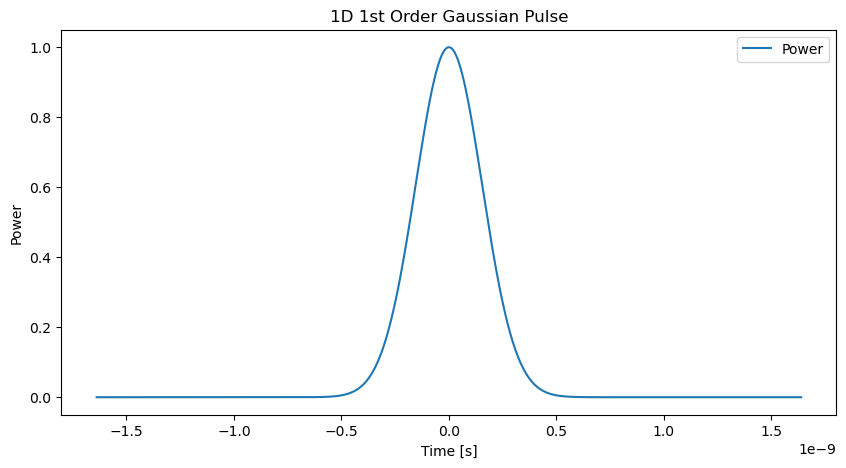

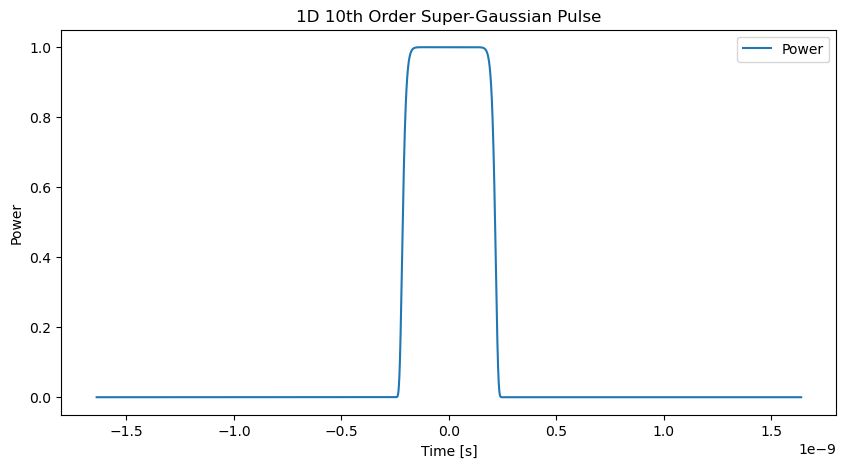

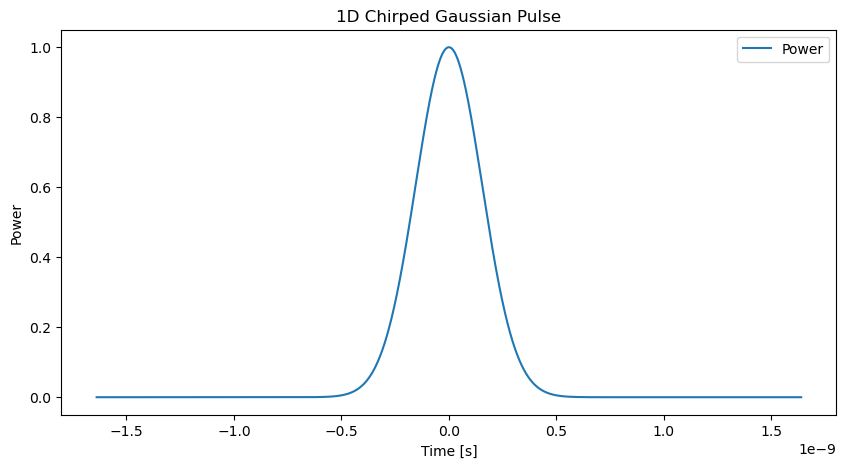

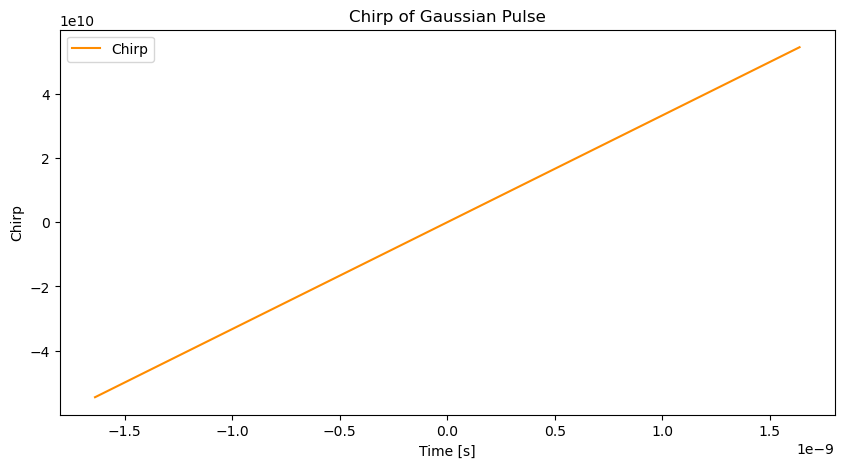

In [10]:
# Initialize Gaussian pulse
amplitude = 1                       # Amplitude in units of sqrt(W)
duration  = 3**7*sim_config.time_step   # Pulse 1/e^2 duration [s]
offset    = 0                       # Time offset
testChirp = 0
testOrder = 1
testCarrierFreq = 0

# 1D First Order Pulse
testPulse = GaussianPulse(t, amplitude, duration, offset,testChirp,testOrder)

plt.figure(figsize= (10,5)) # Set figure size
plt.title("1D 1st Order Gaussian Pulse")
plt.plot(t, getPower(testPulse), label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Power")
plt.legend()
plt.show()


# 1D Super (Order = 10) Gaussian Pulse
super_order=10
testPulse_super=GaussianPulse(t, amplitude, duration, offset,testChirp,super_order)

plt.figure(figsize= (10,5)) # Set figure size
plt.title("1D 10th Order Super-Gaussian Pulse")
plt.plot(t, getPower(testPulse_super), label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Power")
plt.legend()
plt.show()


# 1D First Order Pulse with Linear Chirp 1
testPulse_chirp = GaussianPulse(t, amplitude, duration, offset, 10, 1)

plt.figure(figsize= (10,5)) # Set figure size
plt.title("1D Chirped Gaussian Pulse")
plt.plot(t, getPower(testPulse_chirp), label='Power')
plt.xlabel("Time [s]")
plt.ylabel("Power")
plt.legend()
plt.show()

# plot the chirp on sister axis
plt.figure(figsize= (10,5)) # Set figure size
plt.title("Chirp of Gaussian Pulse")
plt.plot(t, getChirp(t,testPulse_chirp), label='Chirp', color = "darkorange")
plt.xlabel("Time [s]")
plt.ylabel("Chirp")
plt.legend()
plt.show()



## Functions for Conduting FFT/DFT and Getting Spectrum of Pulse

In [11]:
def getSpectrumFromPulse(time,pulse_amplitude): # function to get spectrum amplitude (coefficients of each component wavefunction - in complex exponential form) from pulse amplitude
    
    f = getFreqRangeFromTime(time) # make 1D frequency bins - potential component complex-exponential frequencies
    dt = time[1]-time[0] # get 

    spectrum_amplitude = fftshift(fft(pulse_amplitude))*dt #Take FFT and do shift
    
    # Error catching
    pulseEnergy = getEnergy(time, pulse_amplitude) #Get pulse energy
    spectrumEnergy = getEnergy(f, spectrum_amplitude) #Get spectrum energy
    err=np.abs((pulseEnergy/spectrumEnergy-1))
    assert( err<1e-7 ), f'ERROR = {err}: Energy changed when going from Pulse to Spectrum!!!'

    return spectrum_amplitude



# Equivalent function for getting pulse from spectrum
def getPulseFromSpectrum(frequency,spectrum_amplitude):

    time = getTimeFromFrequency(frequency) 
    dt = time[1]-time[0] # get time step
    pulse = ifft(ifftshift(spectrum_amplitude))/dt
    
    # Error catching
    spectrumEnergy=getEnergy(frequency, spectrum_amplitude)
    pulseEnergy = getEnergy(time, pulse)
    err=np.abs((pulseEnergy/spectrumEnergy-1))
    assert( err<1e-7   ), f'ERROR = {err}: Energy changed when going from Spectrum to Pulse!!!'

    return pulse

In [12]:
# Function to Generate spectrum of 1D Gaussian Pulse
def GaussianSpectrum(frequency,amplitude,bandwidth):
    time = getTimeFromFrequency(frequency)
    return getSpectrumFromPulse(time, GaussianPulse(time, amplitude, 1/bandwidth, 0,0,1))

Testing functions:

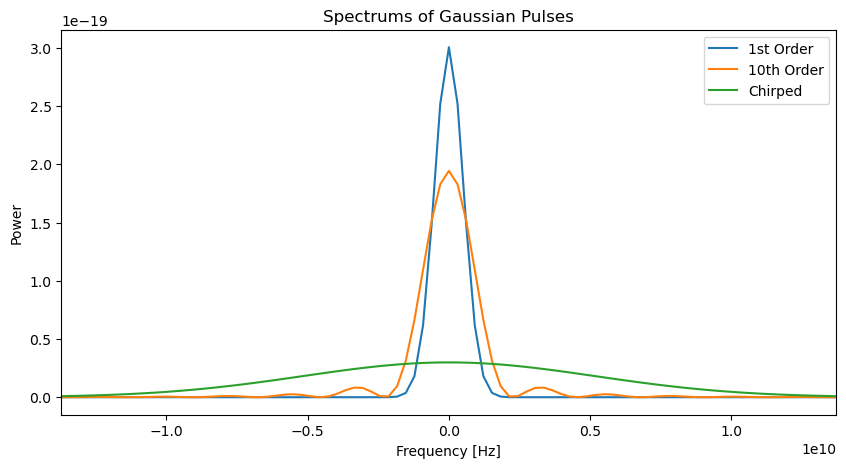

In [13]:
testSpectrum = getSpectrumFromPulse(sim_config.t,testPulse)
testSpectrum_super = getSpectrumFromPulse(sim_config.t,testPulse_super)
testSpectrum_chirp = getSpectrumFromPulse(sim_config.t,testPulse_chirp)

# plotting the spectrums 1D (all in one plot)
plt.figure(figsize=(10,5))
plt.title("Spectrums of Gaussian Pulses")
plt.plot(f, getPower(testSpectrum), label='1st Order')
plt.plot(f, getPower(testSpectrum_super), label='10th Order')
plt.plot(f, getPower(testSpectrum_chirp), label='Chirped')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
# scale x-axis to capture region of interest
plt.xlim(3*-1/(duration), 3*1/(duration))
plt.legend()
plt.show()

# plt.figure()
# plt.title("Spectrum of initial pulse")
# plt.plot(sim_config.f/1e12,getPower(testSpectrum),label="Spectrum of testPulse")
# plt.plot(sim_config.f/1e12,getPower(testSpectrum_2),label="Spectrum generated with GaussianSpectrum")
# plt.axis([-1/duration*2/1e12,1/duration*2/1e12,0,1.1e-21])
# plt.xlabel("Freq. [THz]")
# plt.ylabel("PSD [W/THz]")
# plt.legend()
# plt.show()




## Set up properties of the fiber
Discretizing the fiber aling which we will propagate and also setting its properties.

**Parameters:**
- $\alpha$ - Attenuation
- $\beta_2$ - GVD - $\beta_2 > 0$ is normal dispersion with red light pulling ahead (negative chirp), $\beta_2 < 0$ is anormalous dispersion with blue light pulling ahead (positive chirp)
- $\gamma$ - SPM

In the method we essentially look at effects of the 3 processes (Attenuation, GVD, SPM) separately and incrementally apply them (as if they were the only processes to take place).

In [14]:
#Class for holding info about the fiber
class Fiber_config:
  def __init__(self,nsteps,L,gamma,beta2,alpha_dB_per_m):
      self.nsteps=nsteps
      self.ntraces = self.nsteps+1 #Note: If we want to do 100 steps, we will get 101 calculated pulses (zeroth at the input + 100 computed ones)
      self.Length=L
      self.dz=L/nsteps
      self.zlocs=np.linspace(0,L,self.ntraces) #Locations of each calculated pulse along the fiber
      self.gamma=gamma
      self.beta2=beta2
      self.alpha_dB_per_m=alpha_dB_per_m
      self.alpha_Np_per_m = self.alpha_dB_per_m*np.log(10)/10.0 #Loss coeff is usually specified in dB/km, but Nepers/km is more useful for calculations
      #TODO: Make alpha frequency dependent.

# Define fiberulation parameters
Length          = 1e3      #Fiber length in m
nsteps          = 2**8     #Number of steps we divide the fiber into

gamma           = 10e-3     #Nonlinearity parameter in 1/W/m
beta2           = 100e3    #Dispersion in fs^2/m (units typically used when referring to beta2)
beta2          *= (1e-30)  #Convert fs^2 to s^2 so everything is in SI units
alpha_dB_per_m  = 0.2e-3   #Power attenuation coeff in decibel per m. Usual value at 1550nm is 0.2 dB/km

#Note:  beta2>0 is normal dispersion with red light pulling ahead,
#       causing a negative leading chirp
#
#       beta2<0 is anormalous dispersion with blue light pulling ahead,
#       causing a positive leading chirp.


#  Initialize class
fiber=Fiber_config(nsteps, Length, gamma, beta2, alpha_dB_per_m)


## Define SSFM function
The Split-Step Fourier Method:
1) Applies nonlinearity in time domain (SPM)
2) Goes to spectral domain and applies dispersion and loss in spectral domain
3) Transfers back to time domain

In [37]:
# TODO: Make returning the full matrices optional

def SSFM(fiber:Fiber_config, sim:SIM_config, pulse):

    # Initialize arrays to store pulse and spectrum throughout fiber
    pulseMatrix = np.zeros((fiber.nsteps+1, sim.number_of_points ) )*(1+0j) # size: (number of steps, number of time points) (each row stores pulse at that step)
    spectrumMatrix = np.copy(pulseMatrix)
    pulseMatrix[0,:] = pulse # initialize first row with input pulse
    spectrumMatrix[0,:] = getSpectrumFromPulse(sim.t, pulse) # iniitalize first row with input spectrum

    # Pre-calculate effect of dispersion and loss as it's the same everywhere
    disp_and_loss = np.exp((1j*fiber.beta2/2*(2*pi*sim.f)**2-fiber.alpha_Np_per_m/2)*fiber.dz )

    #Precalculate constants for nonlinearity
    nonlinearity=1j*fiber.gamma*fiber.dz

    for n in range(fiber.nsteps):
        pulse *= np.exp(nonlinearity*getPower(pulse)) # Apply nonlinearity
        spectrum = getSpectrumFromPulse(sim.t, pulse)*disp_and_loss # Go to spectral domain and apply disp and loss
        pulse = getPulseFromSpectrum(sim.f, spectrum) # Return to time domain

        #Store results and repeat
        pulseMatrix[n+1,:]=pulse # update n+1 row with new pulse
        spectrumMatrix[n+1,:]=spectrum # update n+1 row with new spectrum

    #Return results
    return pulseMatrix, spectrumMatrix

#Initial pulse and spectrum

#Run SSFM
pulseMatrix, spectrumMatrix = SSFM(fiber, sim_config, testPulse)



testPulse0 = np.copy(pulseMatrix[0,:])
testSpectrum0 = np.copy(spectrumMatrix[0,:])

testPulseFinal = np.copy(pulseMatrix[-1,:])
testSpectrumFinal = np.copy(spectrumMatrix[-1,:])



## Define functions for plotting pulses and spectra

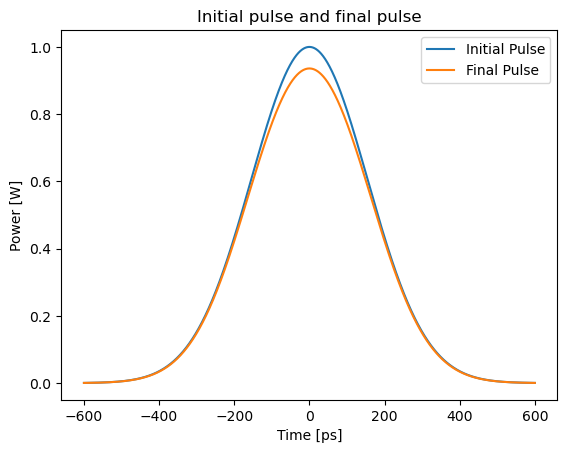

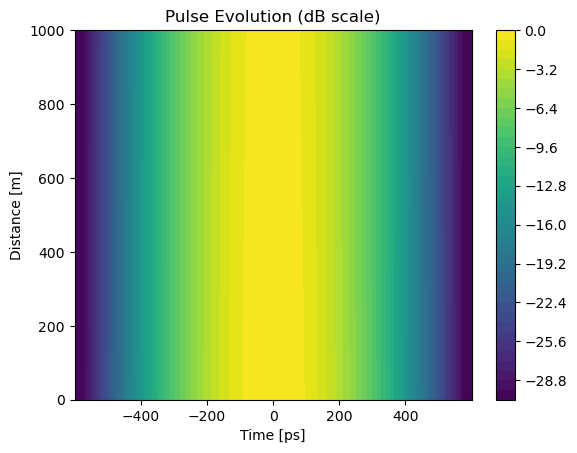

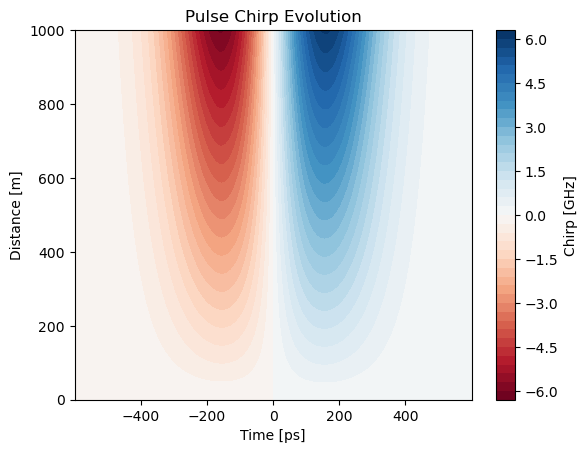

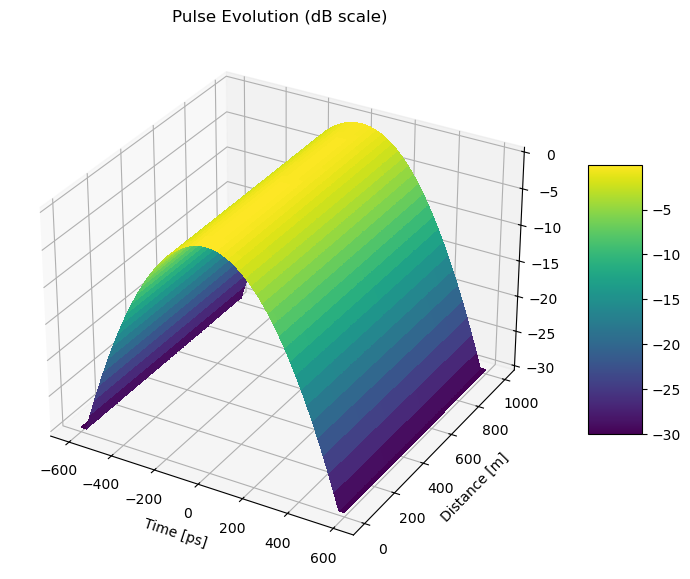

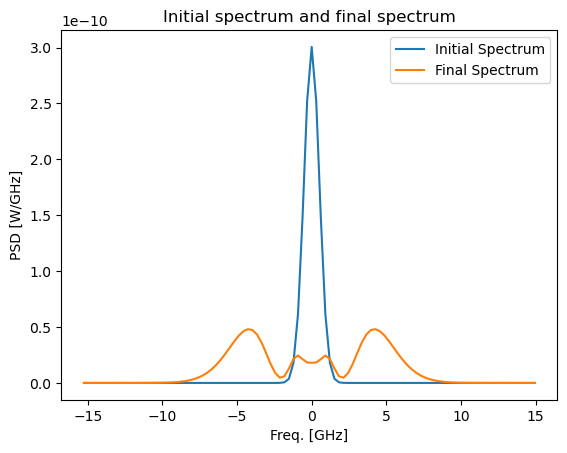

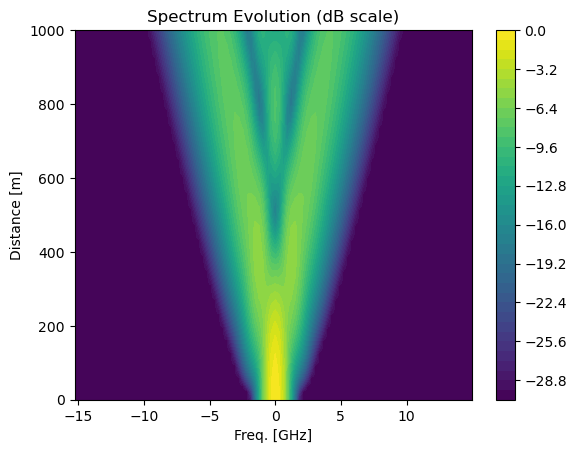

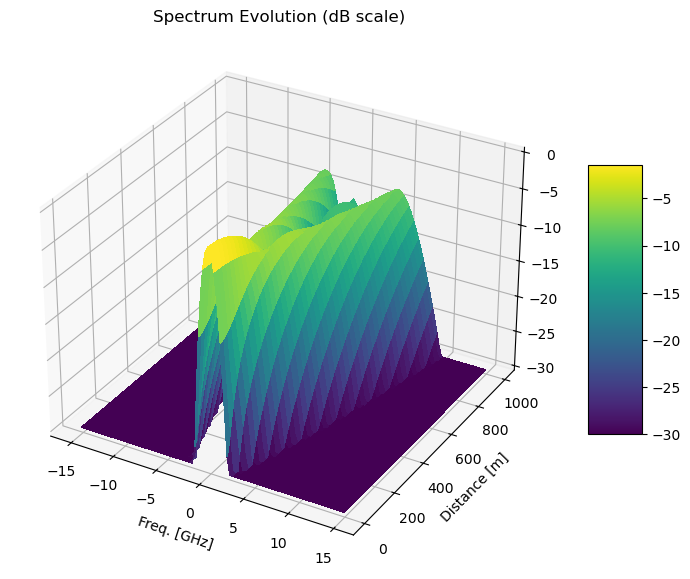

In [16]:
def plotFirstAndLastPulse(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int):
  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  plt.figure()
  plt.title("Initial pulse and final pulse")
  plt.plot(t,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Initial Pulse")
  plt.plot(t,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]),label="Final Pulse")
  plt.xlabel("Time [ps]")
  plt.ylabel("Power [W]")
  plt.legend()
  plt.show()


def plotPulseMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff):
  # Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Evolution (dB scale)')
  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs
  T, Z = np.meshgrid(t, z)
  P = getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P[P < 1e-100] = 1e-100
  P = 10*np.log10(P)
  P[P<dB_cutoff] = dB_cutoff
  surf = ax.contourf(T, Z, P,levels=40)
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  plt.show()

def plotPulseMatrix3D(matrix, fiber:Fiber_config, sim:SIM_config, nrange:int, dB_cutoff):
  # Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Pulse Evolution (dB scale)")

  t = sim.t[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs
  T_surf, Z_surf = np.meshgrid(t, z)
  P_surf = getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100] = 1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf < dB_cutoff] = dB_cutoff
  
  # Plot the surface.
  surf = ax.plot_surface(T_surf, Z_surf, P_surf, cmap=cm.viridis, linewidth=0, antialiased=False)
  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()


def plotPulseChirp2D(matrix, fiber:Fiber_config, sim:SIM_config, nrange:int):
  # Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Pulse Chirp Evolution')
  t = sim.t[int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)]*1e12
  z = fiber.zlocs
  T, Z = np.meshgrid(t, z)

  Cmatrix=np.ones( (len(z),len(t))  )*1.0

  for i in range(fiber.ntraces):
    Cmatrix[i,:]=getChirp(t/1e12,matrix[i,int(sim_config.number_of_points/2-nrange):int(sim_config.number_of_points/2+nrange)])/1e9

  surf=ax.contourf(T, Z, Cmatrix,levels=40,cmap='RdBu')

  ax.set_xlabel('Time [ps]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  cbar.set_label('Chirp [GHz]')
  plt.show()


def plotEverythingAboutPulses(pulseMatrix,fiber:Fiber_config,
                              sim:SIM_config,
                              nrange:int,
                              dB_cutoff):

  print('  ')
  plotFirstAndLastPulse(pulseMatrix,fiber,sim, nrange)
  plotPulseMatrix2D(pulseMatrix,fiber,sim,nrange,dB_cutoff)
  plotPulseChirp2D(pulseMatrix,fiber,sim,nrange)
  plotPulseMatrix3D(pulseMatrix,fiber,sim,nrange,dB_cutoff)

  print('  ')


def plotFirstAndLastSpectrum(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int):
  f=sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  plt.figure()
  plt.title("Initial spectrum and final spectrum")
  plt.plot(f,getPower(matrix[0,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Initial Spectrum")
  plt.plot(f,getPower(matrix[-1,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)])*1e9,label="Final Spectrum")
  plt.xlabel("Freq. [GHz]")
  plt.ylabel("PSD [W/GHz]")
  plt.legend()
  plt.show()

def plotSpectrumMatrix2D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff):
  #Plot pulse evolution throughout fiber in normalized log scale
  fig, ax = plt.subplots()
  ax.set_title('Spectrum Evolution (dB scale)')
  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  z = fiber.zlocs
  F, Z = np.meshgrid(f, z)
  Pf = getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]) / np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  Pf[Pf<1e-100]=1e-100
  Pf = 10*np.log10(Pf)
  Pf[Pf<dB_cutoff]=dB_cutoff
  surf=ax.contourf(F, Z, Pf,levels=40)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  cbar=fig.colorbar(surf, ax=ax)
  plt.show()

def plotSpectrumMatrix3D(matrix,fiber:Fiber_config,sim:SIM_config, nrange:int, dB_cutoff):
  #Plot pulse evolution in 3D
  fig, ax = plt.subplots(1,1, figsize=(10,7),subplot_kw={"projection": "3d"})
  plt.title("Spectrum Evolution (dB scale)")

  f = sim.f[int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]/1e9
  z = fiber.zlocs
  F_surf, Z_surf = np.meshgrid(f, z)
  P_surf=getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]  )/np.max(getPower(matrix[:,int(sim.number_of_points/2-nrange):int(sim.number_of_points/2+nrange)]))
  P_surf[P_surf<1e-100]=1e-100
  P_surf = 10*np.log10(P_surf)
  P_surf[P_surf<dB_cutoff]=dB_cutoff
  # Plot the surface.
  surf = ax.plot_surface(F_surf, Z_surf, P_surf, cmap=cm.viridis,
                        linewidth=0, antialiased=False)
  ax.set_xlabel('Freq. [GHz]')
  ax.set_ylabel('Distance [m]')
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)
  plt.show()


def plotEverythingAboutSpectra(spectrumMatrix,
                               fiber:Fiber_config,
                               sim:SIM_config,
                               nrange:int,
                               dB_cutoff,
                               **kwargs):

  print('  ')
  plotFirstAndLastSpectrum(spectrumMatrix,fiber,sim, nrange)
  plotSpectrumMatrix2D(spectrumMatrix,fiber,sim,nrange,dB_cutoff)
  plotSpectrumMatrix3D(spectrumMatrix,fiber,sim,nrange,dB_cutoff)

  print('  ')


#Plot pulses
nrange=6000
cutoff=-30

plotEverythingAboutPulses(pulseMatrix,fiber,sim_config,nrange,cutoff)

#Plot spectra
nrange=50
cutoff=-30
plotEverythingAboutSpectra(spectrumMatrix,fiber,sim_config,nrange,cutoff)


#TODO: Make plot of evolution of pulse chirp throughout the fiber

## Test that effect of loss calculated with SSFM matches theoretical prediction.

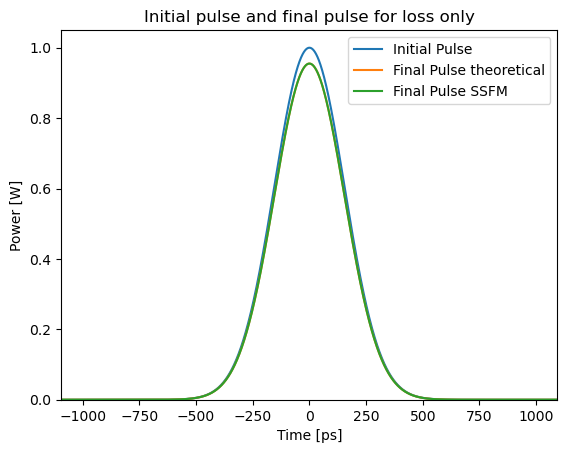

Loss error computed by energy of difference between theory and SSFM is 0.0008808798301459257
Loss error computed by difference of energy between theory and SSFM is 1.1004817945149225e-13


In [17]:
# Define new fiber with only loss
fiber_loss_only=Fiber_config(fiber.nsteps, fiber.Length, 0, 0, fiber.alpha_dB_per_m)

# Apply theoretical effect of loss only
finalPulse_loss_only_theoretical = np.copy(testPulse0)*np.exp(-fiber.alpha_Np_per_m/2*fiber.Length)

# Calculate effect of loss only numerically
pulseMatrix_loss_only_SSFM,spectrumMatrix_loss_only_SSFM = SSFM(fiber_loss_only,sim_config,testPulse)

finalPulse_loss_only_SSFM=pulseMatrix_loss_only_SSFM[-1,:]

# Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final pulse for loss only")
plt.plot(sim_config.t*1e12,getPower(testPulse0),label="Initial Pulse")
plt.plot(sim_config.t*1e12,getPower(finalPulse_loss_only_theoretical),label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getPower(finalPulse_loss_only_SSFM),label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend()
plt.show()


# Quantify error by looking at the energy of the difference between numerical and theoretical result.
loss_err = getEnergy(sim_config.t,(finalPulse_loss_only_SSFM-finalPulse_loss_only_theoretical))/getEnergy(sim_config.t, finalPulse_loss_only_theoretical)
print(f"Loss error computed by energy of difference between theory and SSFM is {loss_err}")


# Alternatively, compute the difference of their two energies
loss_err2 = (getEnergy(sim_config.t,finalPulse_loss_only_SSFM)-getEnergy(sim_config.t,finalPulse_loss_only_theoretical))/getEnergy(sim_config.t, finalPulse_loss_only_theoretical)
print(f"Loss error computed by difference of energy between theory and SSFM is {loss_err2}")


## Test that the effect of GVD calculated by SSFM matches result from theory

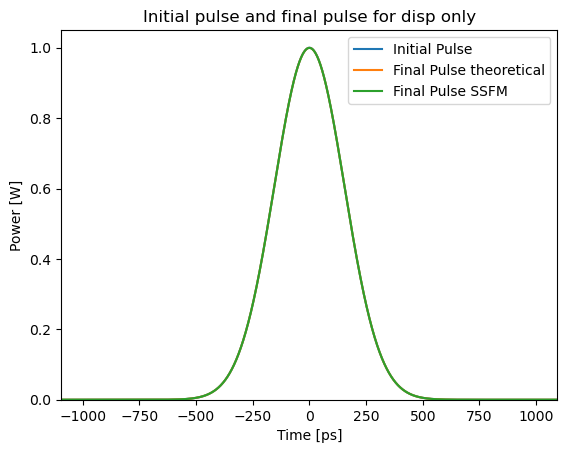

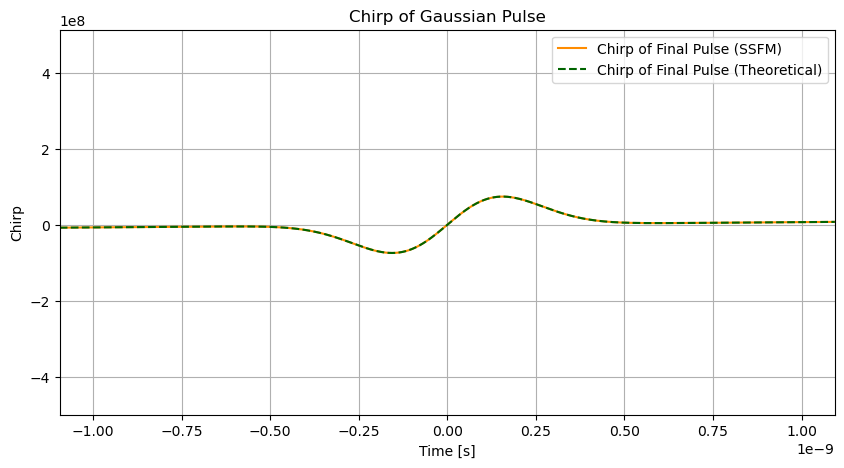

Disp error computed by energy of difference between theory and SSFM is 6.496875024048426e-27
Disp error computed by difference of energy between theory and SSFM is 1.109634551274973e-13


In [36]:
# Define new fiber with only dispersion
fiber_disp_only = Fiber_config(fiber.nsteps, fiber.Length, 0, fiber.beta2, 0)

# Apply theoretical effect of only dispersion
disp_theo = np.exp(1j*fiber_disp_only.beta2/2*(2*pi*sim_config.f)**2*fiber_disp_only.Length )
finalPulse_disp_only_theo = getPulseFromSpectrum(sim_config.f, getSpectrumFromPulse(sim_config.t,testPulse)*disp_theo)

# Calculate disperson only effect numerically
pulseMatrix_disp_only,_ = SSFM(fiber_disp_only,sim_config,testPulse)

finalPulse_disp_only_SSFM = pulseMatrix_disp_only[-1,:]

#Do the orange and green curves match?
plt.figure()
plt.title("Initial pulse and final pulse for disp only")
plt.plot(sim_config.t*1e12,getPower(testPulse0),label="Initial Pulse")
plt.plot(sim_config.t*1e12,getPower(finalPulse_disp_only_theo),label="Final Pulse theoretical")
plt.plot(sim_config.t*1e12,getPower(finalPulse_disp_only_SSFM),label="Final Pulse SSFM")
plt.axis([-duration*5*1e12,duration*5*1e12,0,1.05*amplitude**2])
plt.xlabel("Time [ps]")
plt.ylabel("Power [W]")
plt.legend()
plt.show()


theoChirp = getChirp(sim_config.t,finalPulse_disp_only_theo)
calcChirp = getChirp(sim_config.t,finalPulse_disp_only_SSFM)

# Plot Chirp of both 1D pulses
plt.figure(figsize= (10,5)) # Set figure size
plt.title("Chirp of Gaussian Pulse")
plt.plot(sim_config.t, calcChirp, label='Chirp of Final Pulse (SSFM)', color = "darkorange")
plt.plot(sim_config.t, theoChirp, label='Chirp of Final Pulse (Theoretical)', color = "darkgreen", linestyle='--')
plt.xlim(-duration*5,duration*5)
plt.ylim(0.2*min(theoChirp), 0.2*max(theoChirp))
plt.xlabel("Time [s]")
plt.ylabel("Chirp")
plt.grid()
plt.legend()
plt.show()


#Quantify error by looking at the energy of the difference between numerical and theoretical result.
disp_err = getEnergy(sim_config.t,(finalPulse_disp_only_SSFM-finalPulse_disp_only_theo))/getEnergy(sim_config.t, finalPulse_disp_only_theo)
print(f"Disp error computed by energy of difference between theory and SSFM is {disp_err}")


#Alternatively, compute the difference of their two energies
disp_err2 = (getEnergy(sim_config.t,finalPulse_disp_only_SSFM)-getEnergy(sim_config.t,finalPulse_disp_only_theo))/getEnergy(sim_config.t, finalPulse_disp_only_theo)
print(f"Disp error computed by difference of energy between theory and SSFM is {disp_err2}")

## Test that effect of SPM only matches theoretical prediction

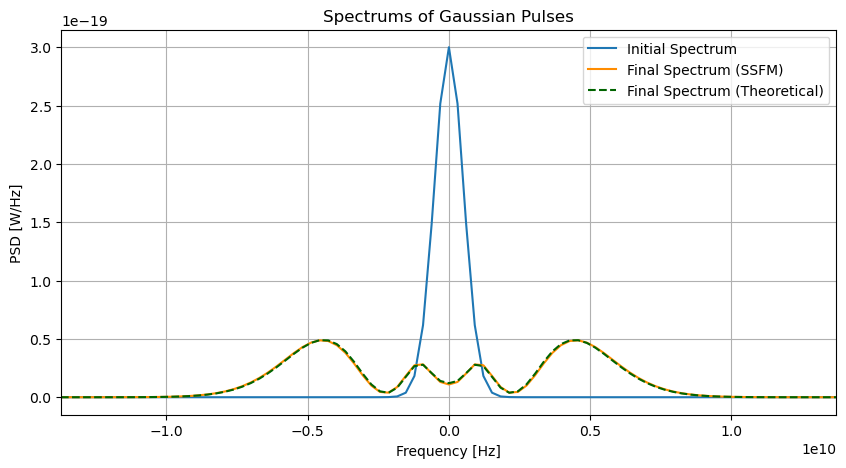

Gamma error computed by energy of difference between theory and SSFM is 0.003522478294126168
Gamma error computed by difference of energy between theory and SSFM is 1.2816812545388434e-13


In [39]:
# Define new fiber with only gamma
fiber_gamma_only = Fiber_config(fiber.nsteps, fiber.Length, fiber.gamma, 0, 0)

# Apply theoretical effect of only gamma
finalPulse_gamma_only_theoretical = np.copy(testPulse0)*np.exp(1j*(fiber_gamma_only.Length)*(fiber_gamma_only.gamma)*getPower(testPulse0))


finalSpectrum_gamma_only_theoretical = getSpectrumFromPulse(sim_config.t,finalPulse_gamma_only_theoretical)


# Calculate disperson only effect numerically
_ , spectrumMatrix_gamma_only_SSFM = SSFM(fiber_gamma_only,sim_config,testPulse) # get spectrum matrix

finalSpectrum_gamma_only_SSFM = spectrumMatrix_gamma_only_SSFM[-1,:] # get final pulse spectrum

# Plot intiial and final spectrum for theoretical and calculated
plt.figure(figsize=(10,5))
plt.title("Spectrums of Gaussian Pulses")
plt.plot(sim_config.f,getPower(testSpectrum0),label="Initial Spectrum")
plt.plot(sim_config.f,getPower(finalSpectrum_gamma_only_SSFM),label="Final Spectrum (SSFM)", color = "darkorange")
plt.plot(sim_config.f,getPower(finalSpectrum_gamma_only_theoretical),label="Final Spectrum (Theoretical)", linestyle='--', color = "darkgreen")
plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [W/Hz]")
plt.xlim(3*-1/(duration), 3*1/(duration))
plt.legend()
plt.grid()
plt.show()



#Quantify error by looking at the energy of the difference between numerical and theoretical result.
gamma_err = getEnergy(sim_config.f,(finalSpectrum_gamma_only_SSFM-finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by energy of difference between theory and SSFM is {gamma_err}")


#Alternatively, compute the difference of their two energies
gamma_err2 = (getEnergy(sim_config.f,finalSpectrum_gamma_only_SSFM)-getEnergy(sim_config.f,finalSpectrum_gamma_only_theoretical))/getEnergy(sim_config.f, finalSpectrum_gamma_only_theoretical)
print(f"Gamma error computed by difference of energy between theory and SSFM is {gamma_err2}")